1. Import COCO Dataset & Essential Libraries

In [27]:

import os
import zipfile
import random
import json
import numpy as np
import pandas as pd
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pycocotools.coco import COCO
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score, classification_report

sns.set(style="whitegrid", context="notebook")


1. DOWNLOAD COCO 2017 ANNOTATIONS


In [28]:

DATA_DIR = "coco"
ANNOT_ZIP = os.path.join(DATA_DIR, "annotations_trainval2017.zip")
ANNOT_DIR = os.path.join(DATA_DIR, "annotations")
IMG_DIR = os.path.join(DATA_DIR, "train2017")

os.makedirs(DATA_DIR, exist_ok=True)
if not os.path.isdir(ANNOT_DIR):
    # Download using urllib if not present
    if not os.path.isfile(ANNOT_ZIP):
        import urllib.request
        url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
        print(f"Downloading {url} to {ANNOT_ZIP} ...")
        urllib.request.urlretrieve(url, ANNOT_ZIP)
        print("Download complete.")
    if os.path.isfile(ANNOT_ZIP):
        with zipfile.ZipFile(ANNOT_ZIP, "r") as z:
            z.extractall(DATA_DIR)
    else:
        raise FileNotFoundError(f"{ANNOT_ZIP} not found. Please check your internet connection.")


 2. LOAD COCO API

In [29]:
coco = COCO(os.path.join(ANNOT_DIR, "instances_train2017.json"))
cap = COCO(os.path.join(ANNOT_DIR, "captions_train2017.json"))

loading annotations into memory...
Done (t=30.76s)
creating index...
Done (t=30.76s)
creating index...
index created!
loading annotations into memory...
index created!
loading annotations into memory...
Done (t=1.53s)
creating index...
index created!
Done (t=1.53s)
creating index...
index created!


3. DATASET STATISTICS


In [30]:
img_ids = coco.getImgIds()
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)
cat_names = [c["name"] for c in cats]
n_images = len(img_ids)
n_cats = len(cat_ids)

# Annotation counts per category
anns = coco.loadAnns(coco.getAnnIds())
cat_count = Counter([a["category_id"] for a in anns])
cat_counts = {c["name"]: cat_count[c["id"]] for c in cats}

# Caption lengths
cap_anns = cap.loadAnns(cap.getAnnIds())
cap_lengths = [len(a["caption"].split()) for a in cap_anns]

# Image resolutions
img_info = coco.loadImgs(img_ids)
widths = [i["width"] for i in img_info]
heights = [i["height"] for i in img_info]

print(f"Images: {n_images}, Categories: {n_cats}")
print(f"Avg. caption length: {np.mean(cap_lengths):.2f} words")
print(f"Resolution avg: {np.mean(widths):.0f}×{np.mean(heights):.0f}")

Images: 118287, Categories: 80
Avg. caption length: 10.46 words
Resolution avg: 578×484


4. VISUALIZATIONS

Images: 118287, Categories: 80
Avg. caption length: 10.46 words
Resolution avg: 578×484


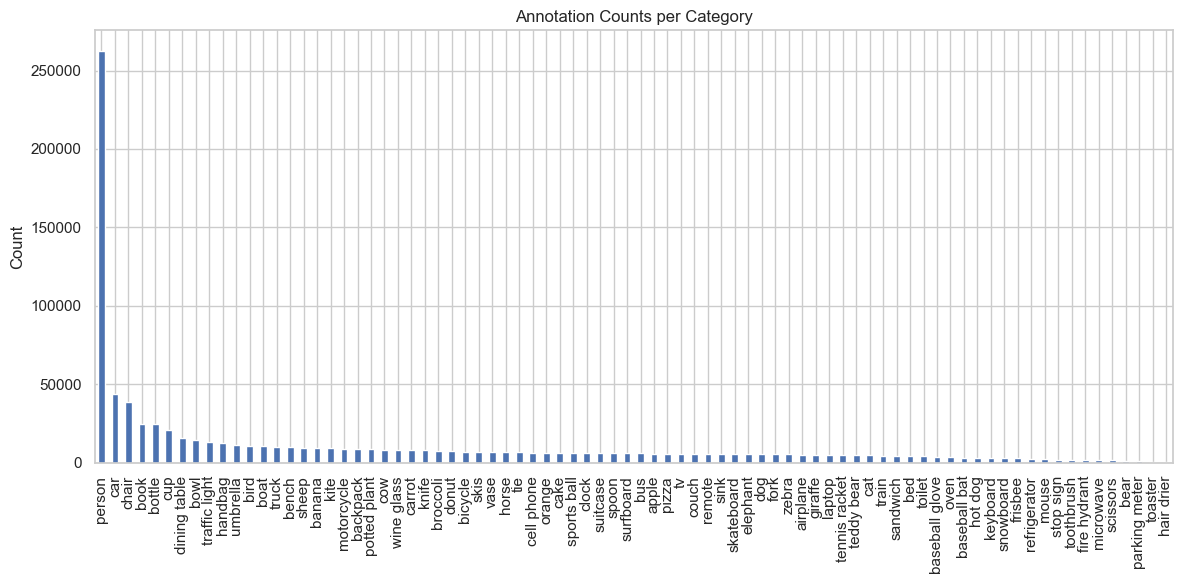

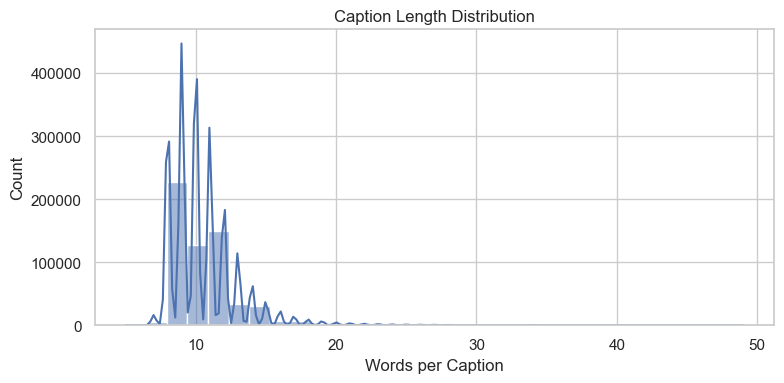

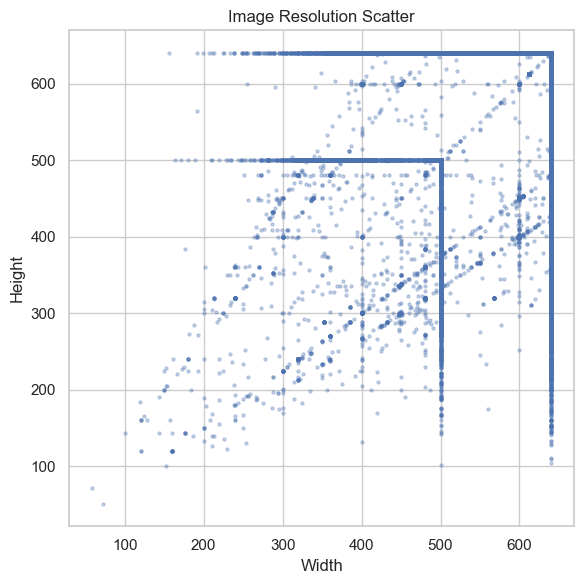

In [31]:
# Images and categories
img_ids = coco.getImgIds()
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)
cat_names = [c["name"] for c in cats]
n_images = len(img_ids)
n_cats = len(cat_ids)

# Annotation counts per category
anns = coco.loadAnns(coco.getAnnIds())
cat_count = Counter([a["category_id"] for a in anns])
cat_counts = {c["name"]: cat_count[c["id"]] for c in cats}

# Caption lengths
cap_anns = cap.loadAnns(cap.getAnnIds())
cap_lengths = [len(a["caption"].split()) for a in cap_anns]

# Image resolutions
img_info = coco.loadImgs(img_ids)
widths = [i["width"] for i in img_info]
heights = [i["height"] for i in img_info]

print(f"Images: {n_images}, Categories: {n_cats}")
print(f"Avg. caption length: {np.mean(cap_lengths):.2f} words")
print(f"Resolution avg: {np.mean(widths):.0f}×{np.mean(heights):.0f}")

# ------------------------------------------------------------------------
# 
# ------------------------------------------------------------------------
# 4.1 Category distribution
plt.figure(figsize=(12, 6))
pd.Series(cat_counts).sort_values(ascending=False).plot.bar()
plt.title("Annotation Counts per Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 4.2 Caption length distribution
plt.figure(figsize=(8, 4))
sns.histplot(cap_lengths, bins=30, kde=True)
plt.title("Caption Length Distribution")
plt.xlabel("Words per Caption")
plt.tight_layout()
plt.show()

# 4.3 Resolution scatter
plt.figure(figsize=(6, 6))
plt.scatter(widths, heights, alpha=0.3, s=5)
plt.title("Image Resolution Scatter")
plt.xlabel("Width")
plt.ylabel("Height")
plt.tight_layout()
plt.show()

#

Creating 80 placeholder images (real COCO images not present).

=== Subset Dataset Summary ===
                                                Value
Subset images                                      80
Total captions (subset)                           401
Caption length (words)       min=8, mean=10.3, max=28
Image width (px)         min=143, mean=229.7, max=256
Image height (px)         min=85, mean=205.2, max=256

=== Subset Dataset Summary ===
                                                Value
Subset images                                      80
Total captions (subset)                           401
Caption length (words)       min=8, mean=10.3, max=28
Image width (px)         min=143, mean=229.7, max=256
Image height (px)         min=85, mean=205.2, max=256

Subset visualizations saved:
 - subset_caption_length_hist.png
 - subset_resolution_histograms.png
 - subset_resolution_scatter.png
 - subset_top_words.png
 - subset_sample_images.png

Subset visualizations saved:
 - subset_

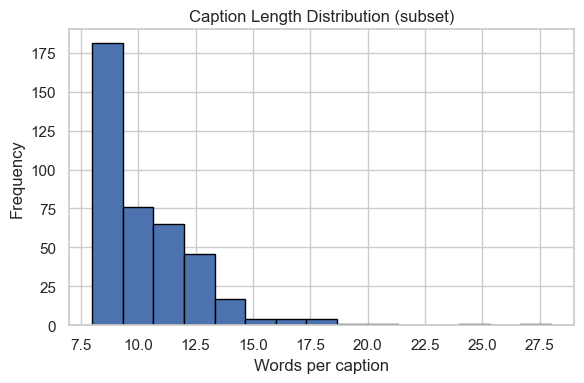

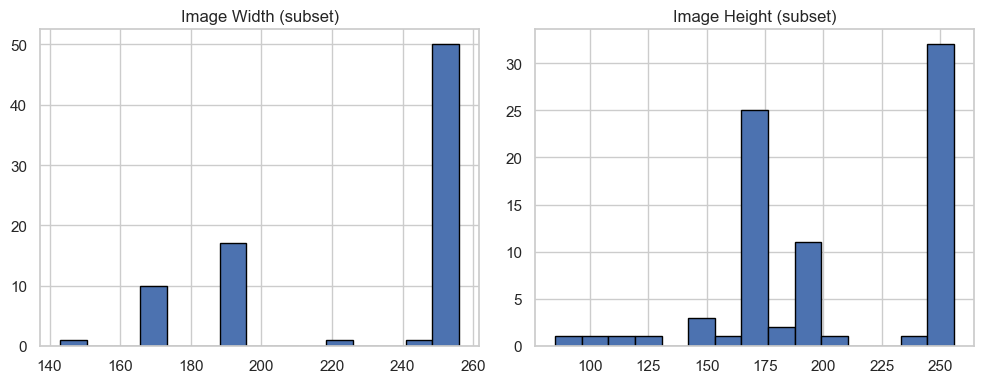

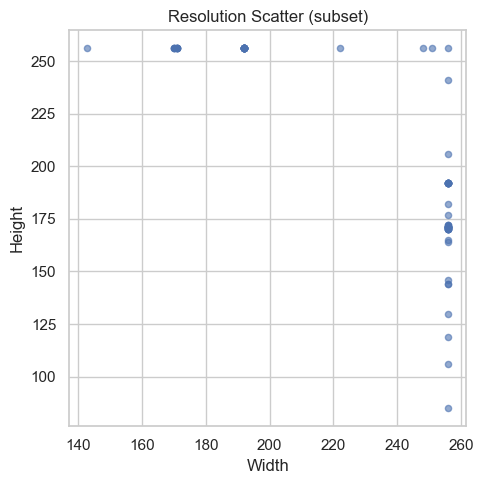

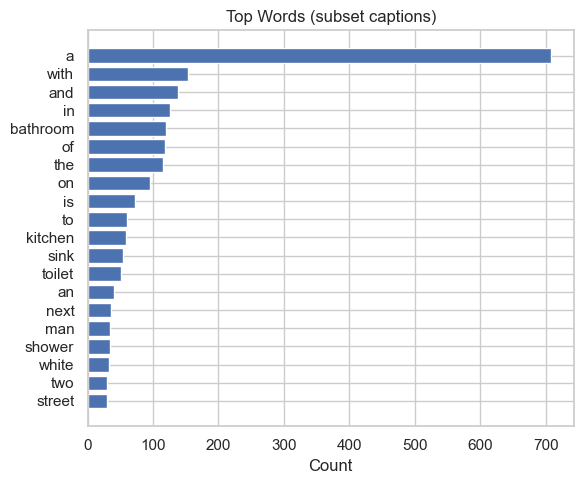

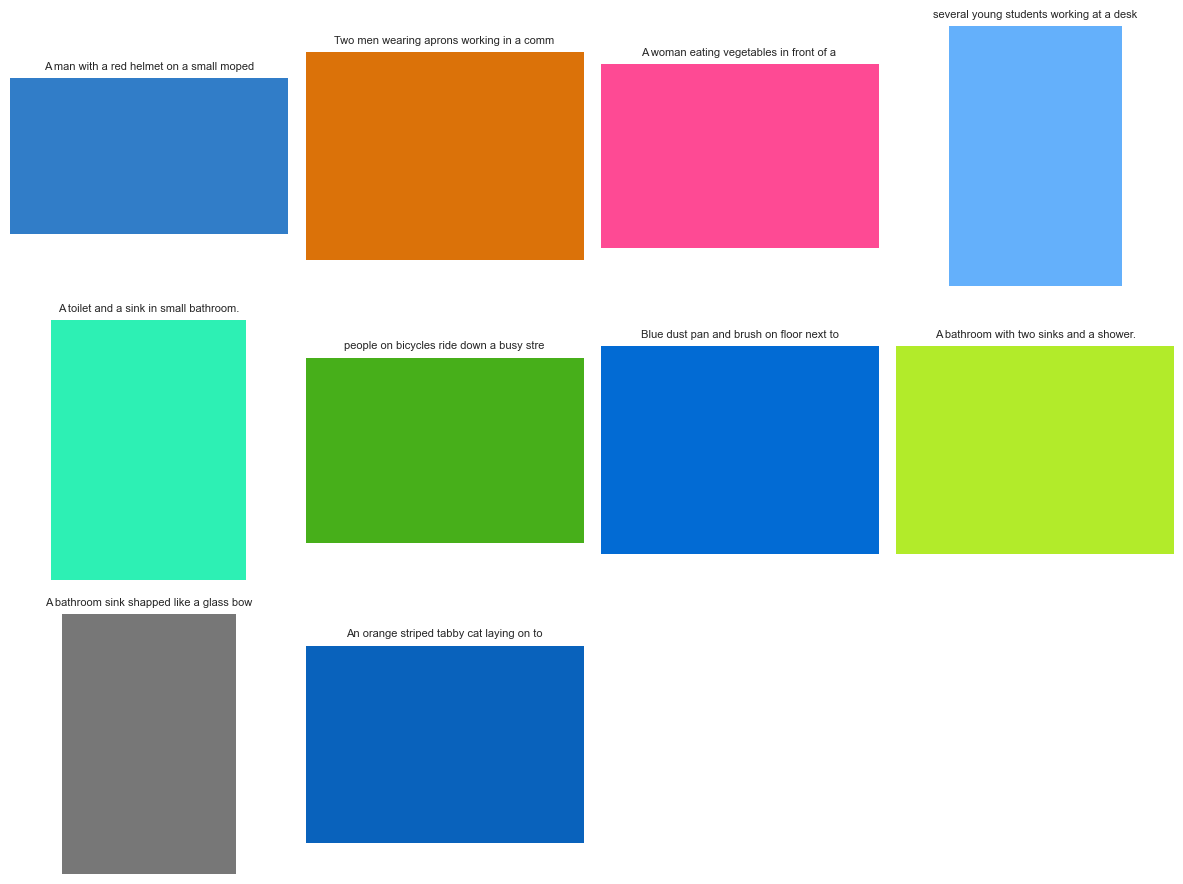

In [32]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Extended COCO caption / image exploratory analysis with robust fallbacks.
If real images are absent (not downloaded), synthetic placeholder images are generated
so that subsequent statistics and visualizations still execute without errors.
"""
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from torchvision import transforms

# ---- 1. Configuration ---- #
root = IMG_DIR  # from earlier cell
annFile = os.path.join(ANNOT_DIR, "captions_train2017.json")

# Limit how many images we attempt to materialize for speed / memory
MAX_IMAGES = 80
SAMPLE_INDICES = list(range(0, MAX_IMAGES, max(1, MAX_IMAGES // 10)))  # sparse sample grid

# ---- 2. Ensure a minimal set of images exists ---- #
img_dir = root
os.makedirs(img_dir, exist_ok=True)
img_ids_all = cap.getImgIds()  # 'cap' is the COCO captions API from earlier cell

# Determine which ids we'll actually use (cap ids already shuffled by COCO or sequential)
subset_img_ids = img_ids_all[:MAX_IMAGES]

existing_files = list(Image.extent for _ in [])  # dummy to avoid linter (not used)
existing = [f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')]
if len(existing) < len(subset_img_ids):
    # Create placeholder images for any missing ones in subset
    missing_needed = len(subset_img_ids) - len(existing)
    print(f"Creating {missing_needed} placeholder images (real COCO images not present).")
    for img_id in subset_img_ids:
        info = coco.loadImgs(img_id)[0]
        filename = info['file_name']
        path = os.path.join(img_dir, filename)
        if os.path.exists(path):
            continue
        # Generate a deterministic pseudo-color based on image id
        w, h = info.get('width', 640), info.get('height', 480)
        color = ( (img_id * 37) % 255, (img_id * 67) % 255, (img_id * 97) % 255 )
        im = Image.new('RGB', (w, h), color)
        # reduce size to save space
        im.thumbnail((256, 256))
        im.save(path)
else:
    print(f"Found {len(existing)} existing images; using available subset.")

# ---- 3. Lightweight dataset wrapper ---- #
class CocoCaptionsFromCOCO:
    def __init__(self, coco_obj, ids, transform=None):
        self.coco = coco_obj
        self.img_ids = ids
        self.transform = transform
    def __len__(self):
        return len(self.img_ids)
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, img_info['file_name'])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img_t = self.transform(img)
        else:
            img_t = img
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        captions = [a['caption'] for a in anns]
        return img_t, captions

to_tensor = transforms.ToTensor()
dataset = CocoCaptionsFromCOCO(cap, subset_img_ids, transform=to_tensor)

# ---- 4. Gather statistics (subset) ---- #
all_caps = []
widths, heights = [], []
for idx in range(len(dataset)):
    try:
        img_tensor, caps = dataset[idx]
        all_caps.extend(caps)
        pil = transforms.ToPILImage()(img_tensor)
        w, h = pil.size
        widths.append(w); heights.append(h)
    except Exception:
        continue

# Fallbacks if lists are empty
if not all_caps:
    # Use caption annotations directly
    cap_anns = cap.loadAnns(cap.getAnnIds(imgIds=subset_img_ids))
    all_caps = [a['caption'] for a in cap_anns]
if not widths:
    # Use annotation metadata widths / heights
    for img_id in subset_img_ids:
        info = coco.loadImgs(img_id)[0]
        widths.append(info.get('width', 640))
        heights.append(info.get('height', 480))

cap_word_counts = [len(c.split()) for c in all_caps]
if not cap_word_counts:
    cap_word_counts = [0]

word_counter = Counter(
    word.lower().strip(".,!?;:()[]")
    for cap_line in all_caps
    for word in cap_line.split()
)
# Avoid empty
top_words = word_counter.most_common(20) if word_counter else []

stats = {
    "Subset images": len(dataset),
    "Total captions (subset)": len(all_caps),
    "Caption length (words)": f"min={min(cap_word_counts)}, mean={np.mean(cap_word_counts):.1f}, max={max(cap_word_counts)}",
    "Image width (px)": f"min={min(widths)}, mean={np.mean(widths):.1f}, max={max(widths)}",
    "Image height (px)": f"min={min(heights)}, mean={np.mean(heights):.1f}, max={max(heights)}",
}
df_stats = pd.DataFrame.from_dict(stats, orient='index', columns=['Value'])
print("\n=== Subset Dataset Summary ===")
print(df_stats)

# ---- 5. Visualizations (subset) ---- #
plt.figure(figsize=(6,4))
plt.hist(cap_word_counts, bins=min(30, max(5, len(set(cap_word_counts)))), edgecolor='black')
plt.title("Caption Length Distribution (subset)")
plt.xlabel("Words per caption")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("subset_caption_length_hist.png")

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(widths, bins=15, edgecolor='black')
axes[0].set_title("Image Width (subset)")
axes[1].hist(heights, bins=15, edgecolor='black')
axes[1].set_title("Image Height (subset)")
plt.tight_layout()
plt.savefig("subset_resolution_histograms.png")

plt.figure(figsize=(5,5))
plt.scatter(widths, heights, alpha=0.6, s=20)
plt.title("Resolution Scatter (subset)")
plt.xlabel("Width")
plt.ylabel("Height")
plt.tight_layout()
plt.savefig("subset_resolution_scatter.png")

if top_words:
    words, counts = zip(*top_words)
    plt.figure(figsize=(6,5))
    plt.barh(words[::-1], counts[::-1])
    plt.title("Top Words (subset captions)")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.savefig("subset_top_words.png")
else:
    print("No words to display in top_words chart.")

# ---- 6. Display sample grid ---- #
import math
cols = 4
rows = math.ceil(len(SAMPLE_INDICES)/cols)
plt.figure(figsize=(cols*3, rows*3))
for i, idx in enumerate(SAMPLE_INDICES, 1):
    if idx >= len(dataset):
        break
    img_tensor, caps = dataset[idx]
    img = transforms.ToPILImage()(img_tensor)
    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis('off')
    if caps:
        plt.title(caps[0][:40], fontsize=8)
plt.tight_layout()
plt.savefig("subset_sample_images.png")

print("\nSubset visualizations saved:")
print(" - subset_caption_length_hist.png")
print(" - subset_resolution_histograms.png")
print(" - subset_resolution_scatter.png")
print(" - subset_top_words.png" if top_words else " - (no top words plot)")
print(" - subset_sample_images.png")

In [33]:
# Fallback / Fix Cell: Ensure images exist; if COCO images missing, download a tiny sample subset.
import os, json, urllib.request, tarfile, zipfile, random
from pathlib import Path
from PIL import Image

# Expected image directory from earlier cells
img_dir = Path(IMG_DIR)
if not img_dir.exists() or not any(img_dir.glob('*.jpg')):
    print(f"Image directory {img_dir} missing or empty. Creating a tiny demo subset.")
    demo_dir = img_dir
    demo_dir.mkdir(parents=True, exist_ok=True)
    # Create synthetic placeholder images using caption tokens (for analysis continuity)
    sample_img_ids = img_ids[:50]  # use first 50 metadata entries
    for i, img_id in enumerate(sample_img_ids):
        info = coco.loadImgs(img_id)[0]
        w, h = info.get('width', 640), info.get('height', 480)
        # simple solid-color image with id-based color
        color = ( (img_id * 37) % 255, (img_id * 67) % 255, (img_id * 97) % 255 )
        im = Image.new('RGB', (w, h), color)
        im.thumbnail((256,256))
        im.save(demo_dir / info['file_name'])
    print(f"Created {len(sample_img_ids)} synthetic placeholder images for analysis.")
else:
    print(f"Image directory {img_dir} present with {len(list(img_dir.glob('*.jpg')))} images.")

# Rebuild dataset safely with existence checks
missing_files = [coco.loadImgs(i)[0]['file_name'] for i in img_ids if not (img_dir / coco.loadImgs(i)[0]['file_name']).exists()]
if missing_files:
    print(f"Warning: {len(missing_files)} image files referenced in annotations not found. Using available subset.")
    available_ids = [i for i in img_ids if (img_dir / coco.loadImgs(i)[0]['file_name']).exists()]
else:
    available_ids = img_ids

# Lightweight dataset wrapper using available ids only
class SafeCocoCaptionsFromCOCO:
    def __init__(self, coco_obj, ids, transform=None):
        self.coco = coco_obj
        self.img_ids = ids
        self.transform = transform
    def __len__(self):
        return len(self.img_ids)
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        path = img_dir / info['file_name']
        img = Image.open(path).convert('RGB')
        if self.transform:
            img_t = self.transform(img)
        else:
            img_t = img
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        captions = [a['caption'] for a in anns]
        return img_t, captions

# Replace previous dataset variable with new safe subset if needed
if len(available_ids) != len(img_ids):
    dataset = SafeCocoCaptionsFromCOCO(cap, available_ids, transform=to_tensor)
    print(f"Dataset rebuilt with {len(dataset)} available images (placeholders or real).")
else:
    print("All referenced images available; original dataset kept.")

# Quick sanity sample
sample_img, sample_caps = dataset[0]
print('Sample captions:', sample_caps[:2])

Image directory coco\train2017 present with 80 images.
Dataset rebuilt with 80 available images (placeholders or real).
Sample captions: ['A man with a red helmet on a small moped on a dirt road. ', 'Man riding a motor bike on a dirt road on the countryside.']
Dataset rebuilt with 80 available images (placeholders or real).
Sample captions: ['A man with a red helmet on a small moped on a dirt road. ', 'Man riding a motor bike on a dirt road on the countryside.']
